# Smoothing

Smoothing, or blurring, is usually one the first step of your image processing pipeline. 

There are many reasons for smoothing, but the main one is surely reducing noise, or so-called artefacts that get in the way of your region of interest.

This recipe focus on blurring in the context of drawing edges, so after applying different blur processing on the image, we will see what the impact is on the drawn edges, using a simple canny function call.

In [1]:
(ns balmy-leaves
 (:require
  [opencv4.core :refer :all]
  [opencv4.utils :as u]))

nil

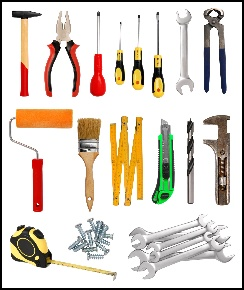

In [3]:
(def neko (-> "resources/tools/set4.jpg" imread (u/resize-by 0.2)     
              (copy-make-border! 2 2 2 2 BORDER_CONSTANT (new-scalar 0 0 0))))

(u/>>> neko)

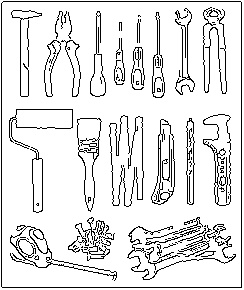

In [4]:
(->
  neko
  (clone)
  (cvt-color! COLOR_RGB2GRAY)
  (canny! 300.0 100.0 3 true)
  (bitwise-not!)
  (u/>>>)  )

We will use a simple annotate function to mark the image with the factor used to generate images.

In [5]:
(defn annotate![mat text]
 (put-text mat
  text (new-point 20 20) FONT_HERSHEY_PLAIN 1 (new-scalar 0 0 0) 1)
 mat)

#'balmy-leaves/annotate!

## Median Filter 

The median filter run through each element of the signal (in this case the image) and replace each pixel with the median of its neighboring pixels (located in a square neighborhood around the evaluated pixel).


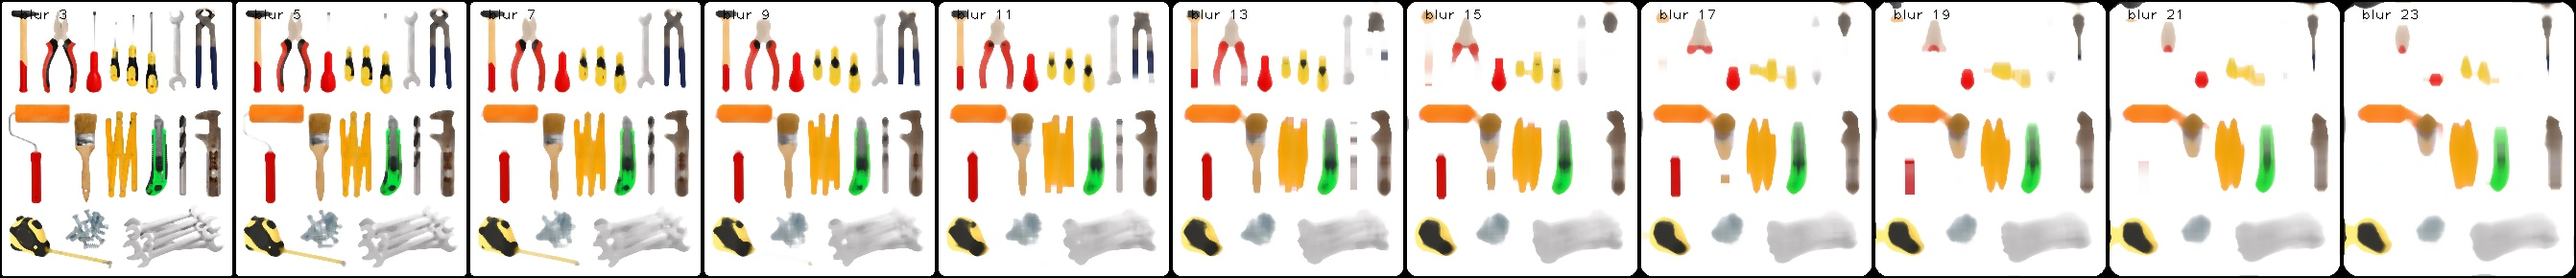

In [10]:
(u/>>>
    (hconcat!
      (map   
        #(-> neko clone(median-blur! %) (annotate! (str "blur " %))) 
          (filter odd? (range 3 25)))))

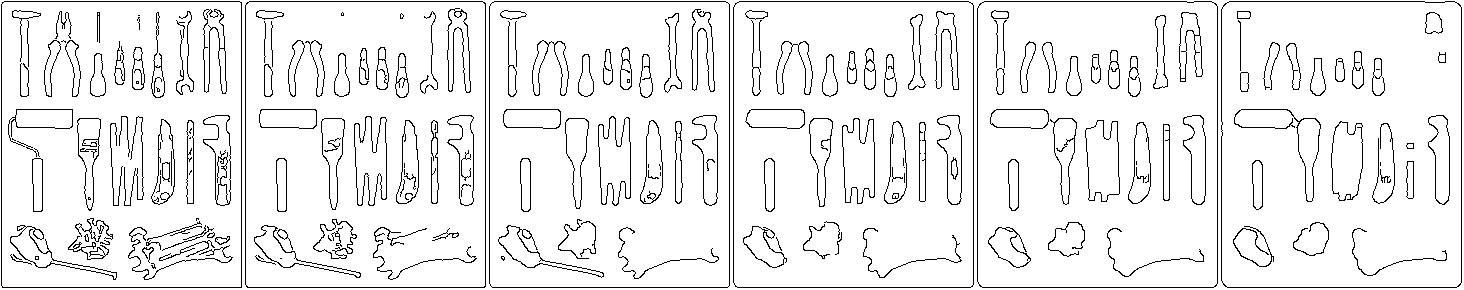

In [11]:
(u/>>>
    (hconcat!
        (map  
    #(-> neko 
     (clone)  
     (median-blur! %)
     (cvt-color! COLOR_RGB2GRAY)
     (canny! 300.0 100.0 3 true)
     (bitwise-not!))
(filter odd? (range 3 15)))))

So while the blur effect looks really nice on the picture itself, the edges are actually disappearing and 

## Normalized box filter

This filter is the simplest of all! Each output pixel is the mean of its kernel neighbors ( all of them contribute with equal weights)

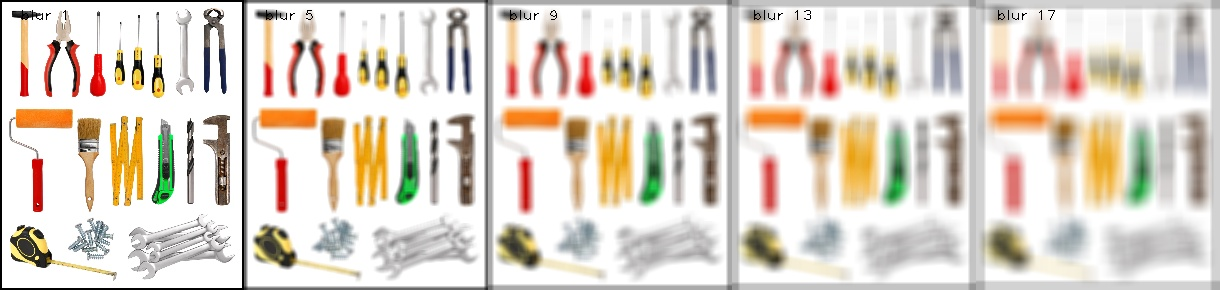

In [14]:
(u/>>>
    (hconcat!
    (map  
  #(-> neko 
       (clone)
       (blur! (new-size % %) (new-point -1 -1)) 
       (annotate! (str "blur " %)) )
  (take-nth 2 (filter odd? (range 0 20))))))

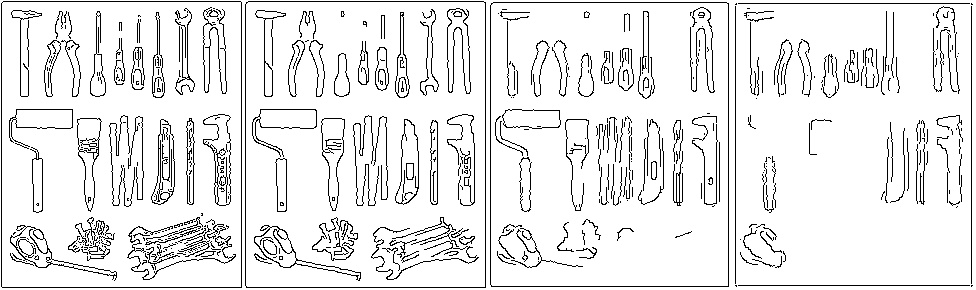

In [15]:

(u/>>>
    (hconcat!
        (map  
  #(-> neko 
       (clone) 
       (blur! (new-size % %) (new-point -1 -1)) 
       (cvt-color! COLOR_RGB2GRAY)
       (canny! 200.0 100.0 3 true)
       (bitwise-not!))
  
  (filter odd? (range 0 9)))))

## Gaussian Blur

Probably the most useful filter (although not the fastest). Gaussian filtering is done by convolving each point in the input array with a Gaussian kernel and then summing them all to produce the output array.


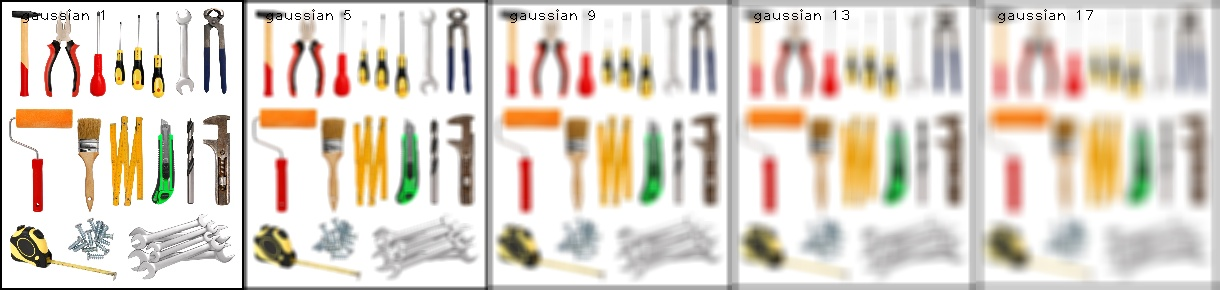

In [16]:
(u/>>>
    (hconcat!
        (map  
  #(-> neko 
       (clone)
       (gaussian-blur! (new-size % %) 10) 
       (annotate! (str "gaussian " %)))
  (take-nth 2 (filter odd? (range 0 20))))))

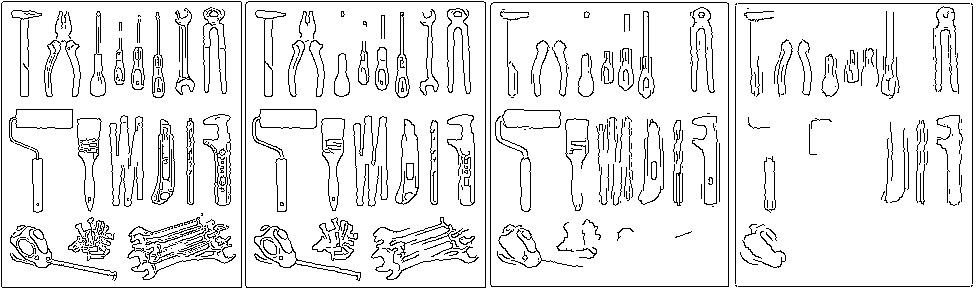

In [17]:
(u/>>>
    (hconcat!
        (map  
  #(-> neko 
       (clone)
       (gaussian-blur! (new-size % %) 10) 
       (cvt-color! COLOR_RGB2GRAY)
       (canny! 200.0 100.0 3 true)
       (bitwise-not!))
  (filter odd? (range 0 9)))))

The one before last picture presents keeps the most important features and should be easy to analyse. Most of the time you would actually use a gaussian-blur.

## Bilateral Filter

So far, we have explained some filters which main goal is to smooth an input image. However, sometimes the filters do not only dissolve the noise, but also smooth away the edges. 

To avoid this (at certain extent at least), we can use a bilateral filter.
In an analogous way as the Gaussian filter, the bilateral filter also considers the neighboring pixels with weights assigned to each of them. 

These weights have two components, the first of which is the same weighting used by the Gaussian filter. The second component takes into account the difference in intensity between the neighboring pixels and the evaluated one.

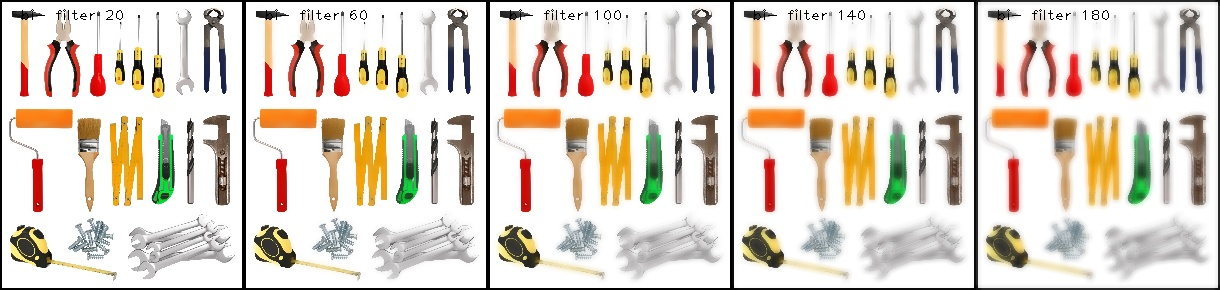

In [18]:
(u/>>>
    (hconcat!
    (map  
  #(-> neko 
       (clone)
       (bilateral-filter! 10 (* 2 %) (/ % 2))
       (annotate! (str "bi- filter " %)) )
  (take-nth 40 (range 20 201)))))


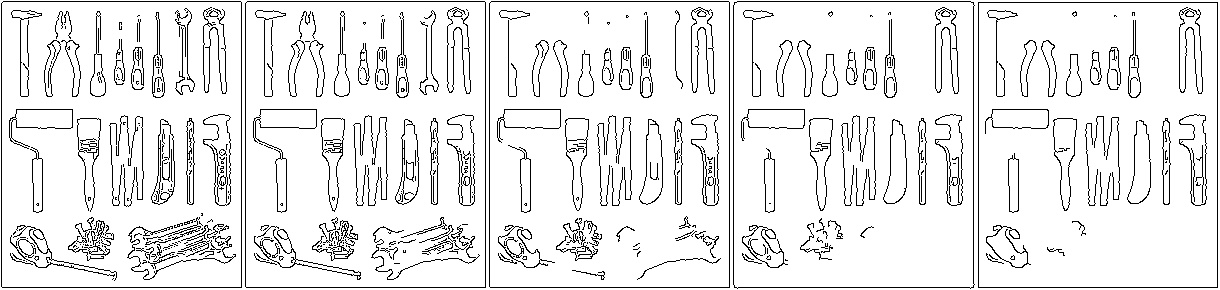

In [19]:
(u/>>>
    (hconcat!
        (map  
  
  #(-> neko 
    (clone)
    (bilateral-filter! 10 (* 2 %) (/ % 2))
    (cvt-color! COLOR_RGB2GRAY)
    (canny! 200.0 100.0 3 true)
    (bitwise-not!))

  (take-nth 40 (range 20 200)))))

The last picture in the series, shows a set of tools that are much easier to identify and so should be a good start for analyzing the content of the picture.

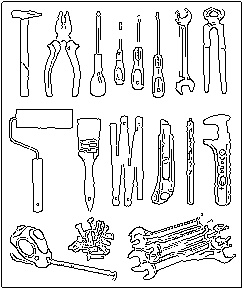

In [20]:
(def best
  (-> neko 
    (clone)
    (bilateral-filter! 10 (* 2 20) (/ 20 2))
    (cvt-color! COLOR_RGB2GRAY)
    (canny! 200.0 100.0 3 true)
    (bitwise-not!)))

(u/>>> best)

In [21]:
(def contours (new-arraylist))
(find-contours best contours (new-mat) RETR_LIST CHAIN_APPROX_TC89_KCOS)

nil

In [22]:
(defn draw-contours-with-line! [img contours]
(dotimes [i (.size contours)]
   (let [c (.get contours i)
      m2f (new-matofpoint2f (.toArray c))
      len (arc-length m2f true)
      ret (new-matofpoint2f)
      approx (approx-poly-dp m2f ret (* 0.1 len) true)
      nb-sides (.size (.toList ret))]
;(spit "test.log" (str ">" nb-sides) :append true)
(draw-contours img contours i
 (condp = nb-sides
  11  (new-scalar 56.09 68.05 66.27)
  6  (new-scalar 356.09 51.57 43.73)
  4  (new-scalar 26.09 51.57 43.73)
  13  (new-scalar 146.09 51.57 43.73)
  5  (new-scalar 266.09 51.57 43.73)
  8 (new-scalar 236.09 51.57 43.73)
  16 (new-scalar 206.09 68.05 66.27)
  21 (new-scalar 0 0 255)
     (new-scalar 127 50 0))
  1)))
 img)

#'balmy-leaves/draw-contours-with-line!

1173


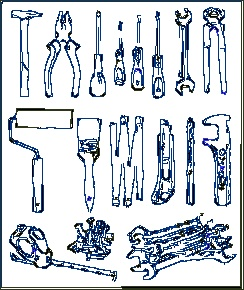

In [23]:
(def output (-> best clone  (cvt-color! COLOR_GRAY2RGB)))
(println (count contours))
(draw-contours-with-line! output contours)

(u/>>> output)